In [1]:
# !pip install pytz
# !pip install networkx
# !pip install pyyaml

In [1]:
import os
import logging
from pytz import timezone
from datetime import datetime
import numpy as np

from data_loader import SyntheticDataset
from models import NoTears
from trainers import ALTrainer
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

# For logging of tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Get arguments parsed
args = get_train_args()

args.n = 1629
args.d = 64

In [3]:
# Setup for logging
output_dir = 'output/{}'.format(datetime.now(timezone('Canada/Central')).strftime('%Y-%m-%d_%H-%M-%S-%f')[:-3])
create_dir(output_dir)
LogHelper.setup(log_path='{}/training.log'.format(output_dir), level_str='INFO')
_logger = logging.getLogger(__name__)

# Save the configuration for logging purpose
save_yaml_config(args, path='{}/config.yaml'.format(output_dir))

# Reproducibility
set_seed(args.seed)

# Get dataset
dataset = SyntheticDataset(args.n, args.d, args.graph_type, args.degree, args.sem_type,
                           args.noise_scale, args.dataset_type)
_logger.info('Finished generating dataset')

2022-04-03 00:58:14,296 INFO - helpers.log_helper - Finished configuring logger.
2022-04-03 00:58:14,305 INFO - __main__ - Finished generating dataset


In [4]:
import pandas as pd

headers = pd.read_csv('nhefs.csv', nrows=0).columns.tolist()

X = pd.read_csv("nhefs.csv", skiprows = 1, header=None)
X = X.fillna(-1).reset_index(drop=True)
X = (X-X.mean())/X.std()
X = X.to_numpy()

In [5]:
dataset.X = X
dataset.X.shape

(1629, 64)

In [6]:
dataset.W.shape

(64, 64)

In [15]:
args.use_float64

False

In [20]:
model = NoTears(args.n, args.d, args.seed, args.l1_lambda, args.use_float64)
model.print_summary(print_func=model.logger.info)

trainer = ALTrainer(args.init_rho, args.rho_max, args.h_factor, args.rho_multiply,
                    args.init_iter, args.learning_rate, args.h_tol)

2022-04-03 01:25:53,695 INFO - models.notears - Model summary:
2022-04-03 01:25:53,695 INFO - models.notears - ---------
2022-04-03 01:25:53,696 INFO - models.notears - Variables: name (type shape) [size]
2022-04-03 01:25:53,696 INFO - models.notears - ---------
2022-04-03 01:25:53,696 INFO - models.notears - Variable:0 (float32 64x64) [4096, bytes: 16384]
2022-04-03 01:25:53,697 INFO - models.notears - Total size of variables: 4096
2022-04-03 01:25:53,697 INFO - models.notears - Total bytes of variables: 16384


In [21]:
# predict
W_est = trainer.train(model, dataset.X, dataset.W, args.graph_thres,
                      args.max_iter, args.iter_step, output_dir)
_logger.info('Finished training model')

2022-04-03 01:25:56,110 INFO - trainers.al_trainer - Started training for 20 iterations
2022-04-03 01:25:56,110 INFO - trainers.al_trainer - rho 1.000E+00, alpha 0.000E+00
2022-04-03 01:25:59,496 INFO - trainers.al_trainer - [Iter 1] loss 1.661E+01, mse 5.339E+04, acyclic 6.633E-01, shd 153, tpr 0.000, fdr 1.000, pred_size 35
2022-04-03 01:25:59,497 INFO - trainers.al_trainer - rho 1.000E+00, alpha 6.633E-01
2022-04-03 01:26:02,748 INFO - trainers.al_trainer - rho 1.000E+01, alpha 6.633E-01
2022-04-03 01:26:06,036 INFO - trainers.al_trainer - rho 1.000E+02, alpha 6.633E-01
2022-04-03 01:26:09,398 INFO - trainers.al_trainer - [Iter 2] loss 1.765E+01, mse 5.665E+04, acyclic 6.540E-02, shd 199, tpr 0.017, fdr 0.976, pred_size 85
2022-04-03 01:26:09,399 INFO - trainers.al_trainer - rho 1.000E+02, alpha 7.203E+00
2022-04-03 01:26:12,999 INFO - trainers.al_trainer - rho 1.000E+03, alpha 7.203E+00
2022-04-03 01:26:16,781 INFO - trainers.al_trainer - rho 1.000E+04, alpha 7.203E+00
2022-04-03 0

In [8]:
# Save raw estimated graph, ground truth and observational data after training
np.save('{}/true_graph.npy'.format(output_dir), dataset.W)
np.save('{}/X.npy'.format(output_dir), dataset.X)
np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)

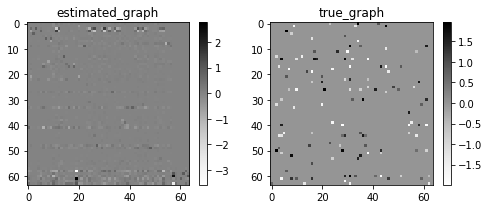

2022-04-03 00:59:26,215 INFO - __main__ - Thresholding.


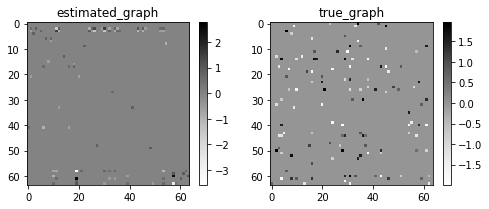

2022-04-03 00:59:26,534 INFO - __main__ - Results after thresholding by 0.5: {'fdr': 0.9764705882352941, 'tpr': 0.01652892561983471, 'fpr': 0.043799472295514515, 'shd': 200, 'pred_size': 85}


In [9]:
# Plot raw estimated graph
plot_estimated_graph(W_est, dataset.W,
                     save_name='{}/raw_estimated_graph.png'.format(output_dir))

_logger.info('Thresholding.')
# Plot thresholded estimated graph
args.graph_thres = 0.5
W_est[np.abs(W_est) < args.graph_thres] = 0    # Thresholding
plot_estimated_graph(W_est, dataset.W,
                     save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
results_thresholded = count_accuracy(dataset.W, W_est)
_logger.info('Results after thresholding by {}: {}'.format(args.graph_thres, results_thresholded))

In [10]:
W_est

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.5516941, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [11]:
args.graph_thres

0.5

In [10]:
#result_matrix = pd.read_csv("W_true.csv", header=None)

In [11]:
#!apt-get update && apt-get install -y graphviz
#!pip install lingam

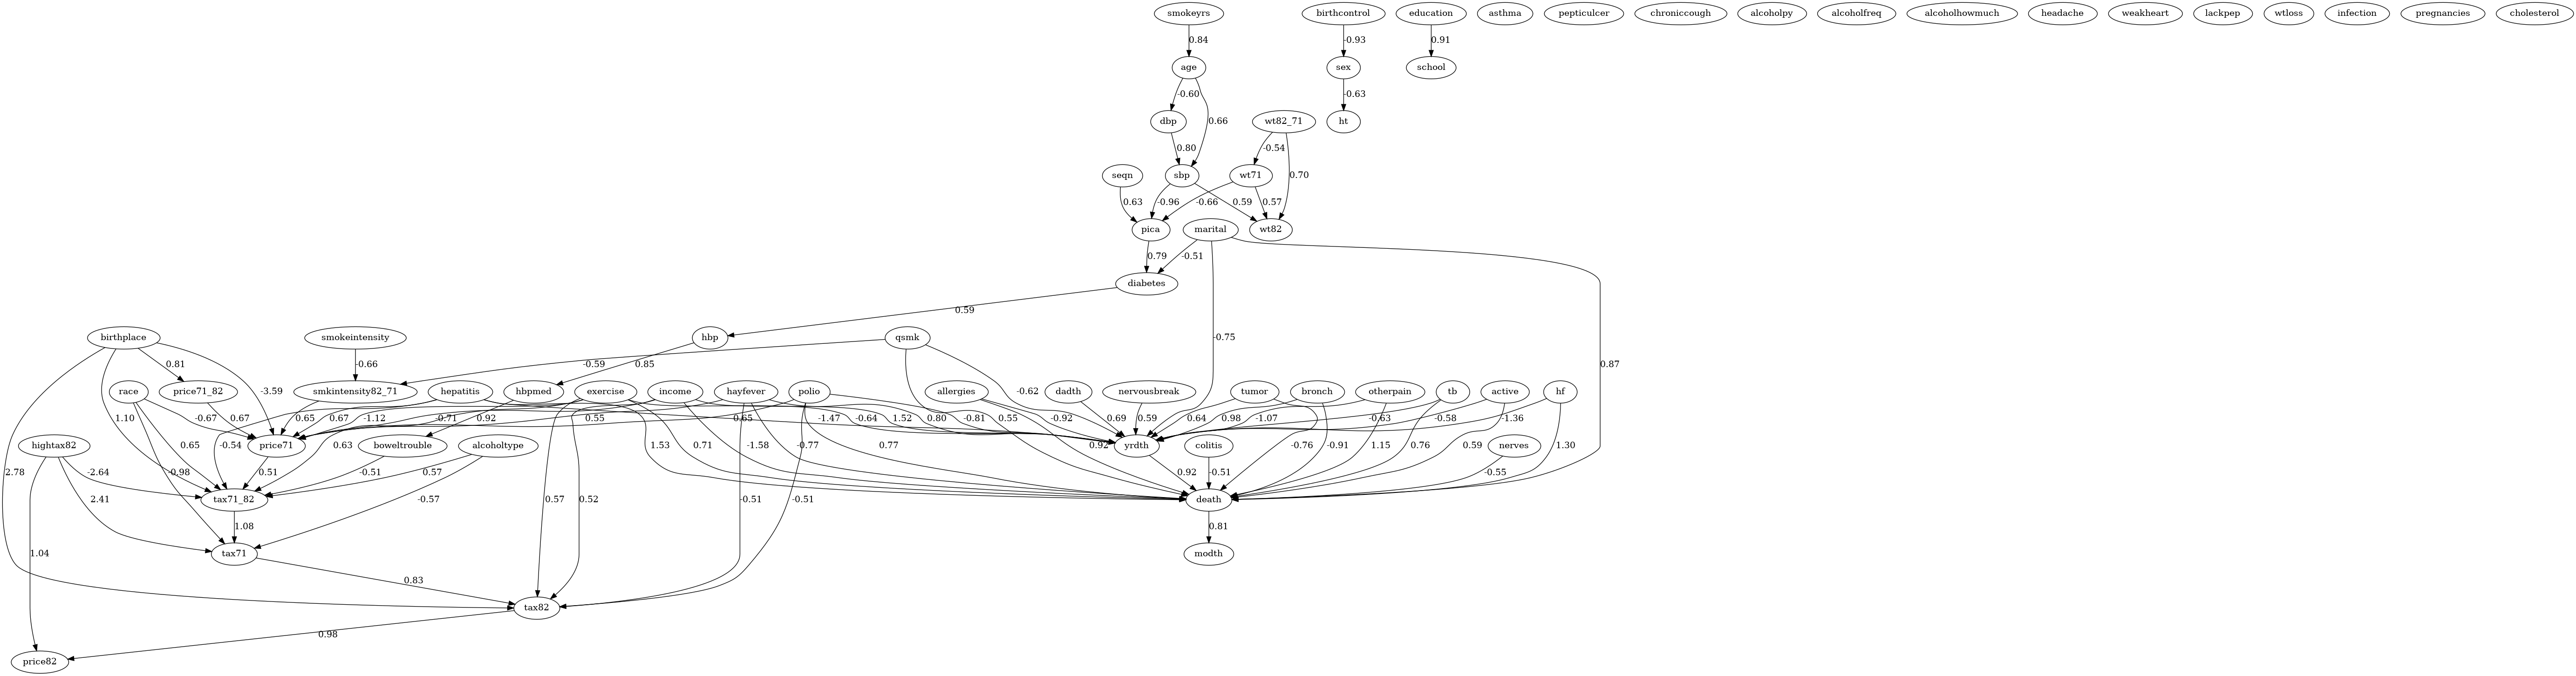

In [12]:
from lingam.utils import make_dot

dot = make_dot(W_est, labels=headers)

# Save png
dot.format = 'png'
dag_path = dot.render('dag')

from IPython.display import Image
Image(filename=dag_path) 